In [1]:
# Downloading the Dataset

!pip install opendatasets --quiet

import opendatasets as od

od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Skipping, found downloaded files in "./brain-tumor-mri-dataset" (use force=True to force download)


In [18]:
# Importing requirments

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
# Create model directory
MODEL_DIR = Path("model")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"Model directory created at: {MODEL_DIR}")

Model directory created at: model


In [4]:
# Declaring the Path of the Training and testing Dataset

train_dir = "/home/kavin/Documents/Projects/Machine_Learning/PyTorch/Brain-Tumor-MRI-CNN/brain-tumor-mri-dataset/Training"

test_dir = "/home/kavin/Documents/Projects/Machine_Learning/PyTorch/Brain-Tumor-MRI-CNN/brain-tumor-mri-dataset/Testing"

print(f"Training Dataset: {train_dir}")
print(f"Testing Dataset: {test_dir}")

Training Dataset: /home/kavin/Documents/Projects/Machine_Learning/PyTorch/Brain-Tumor-MRI-CNN/brain-tumor-mri-dataset/Training
Testing Dataset: /home/kavin/Documents/Projects/Machine_Learning/PyTorch/Brain-Tumor-MRI-CNN/brain-tumor-mri-dataset/Testing


In [5]:
# Data Preprocessing

BATCH_SIZE = 16


data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder(train_dir, transform = data_transform)
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)


test_data = ImageFolder(test_dir, transform = data_transform)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = True)


len(train_dataloader), len(test_dataloader), len(train_data), len(test_data)

(357, 82, 5712, 1311)

In [6]:
class_names = train_data.classes
class_to_index = train_data.class_to_idx

print(f"Labels: {class_names}")
print(f"Label Index: {class_to_index}")

Labels: ['glioma', 'meningioma', 'notumor', 'pituitary']
Label Index: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


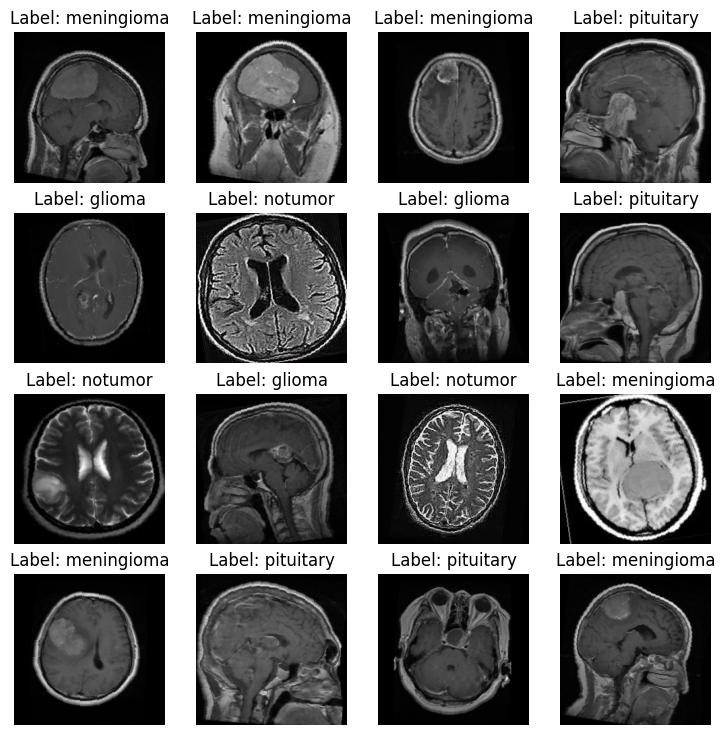

In [7]:
# Plotting the images

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean



for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    img = denormalize(img)
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.title(F"Label: {class_names[label]}")
    plt.axis('off')


plt.show()

In [8]:
class TumorClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(32*56*56, 128),
            nn.ReLU(),
            nn.Linear(128, len(class_names))
        )

    def forward(self, x):
        x = self.layer_block1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
model = TumorClassifier().to(device)
model

TumorClassifier(
  (layer_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [10]:
# Loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# def accuracy_fn(y_true, y_pred):
#     correct = torch.eq(y_true, y_pred).sum().item()
#     acc = (correct / len(y_pred)) * 100
#     return acc

def accuracy_fn(y_true, y_pred):
    return torch.eq(y_true, y_pred).sum().item()


In [11]:
# History

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

In [12]:
# Making a training and testing loop
from tqdm.auto import tqdm

epochs = 20

for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch}")
    print("-" * 50)    
    
    train_losses = 0
    train_accs = 0
    train_total = 0 
    
    model.train()
    for batch, (X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        
        train_pred = model(X)
        train_loss = loss_fn(train_pred, y)
        train_acc = accuracy_fn(
            y_true=y, 
            y_pred=train_pred.argmax(dim=1)
        )

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_losses += train_loss.item()
        train_accs += train_acc
        train_total += y.size(0) 
        
    
    train_losses /= len(train_dataloader)
    train_accs = (train_accs / train_total) * 100
    train_loss_history.append(train_losses)
    train_acc_history.append(train_accs)

    test_losses = 0
    test_accs = 0
    test_total = 0   
    
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader):
            X,y = X.to(device), y.to(device)
    
            test_pred = model(X)
            test_loss = loss_fn(test_pred, y)
            test_acc = accuracy_fn(
                y_true=y, 
                y_pred=test_pred.argmax(dim=1)
            )

            test_losses += test_loss.item()
            test_accs += test_acc
            test_total += y.size(0)  
    
  
    test_losses /= len(test_dataloader)
    test_accs = (test_accs / test_total) * 100
    test_loss_history.append(test_losses)
    test_acc_history.append(test_accs)
    
    print(f"Train Loss: {train_losses:.4f} | Train Acc: {train_accs:.2f}%")
    print(f"Test Loss: {test_losses:.4f} | Test Acc: {test_accs:.2f}%")

print("\nTraining complete!")


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
--------------------------------------------------
Train Loss: 0.6858 | Train Acc: 75.58%
Test Loss: 0.5080 | Test Acc: 80.70%

Epoch: 1
--------------------------------------------------
Train Loss: 0.3609 | Train Acc: 86.36%
Test Loss: 0.3304 | Test Acc: 86.58%

Epoch: 2
--------------------------------------------------
Train Loss: 0.2557 | Train Acc: 90.00%
Test Loss: 0.3277 | Test Acc: 86.96%

Epoch: 3
--------------------------------------------------
Train Loss: 0.2048 | Train Acc: 92.93%
Test Loss: 0.2900 | Test Acc: 88.79%

Epoch: 4
--------------------------------------------------
Train Loss: 0.1468 | Train Acc: 94.57%
Test Loss: 0.1913 | Test Acc: 93.29%

Epoch: 5
--------------------------------------------------
Train Loss: 0.1077 | Train Acc: 95.96%
Test Loss: 0.2500 | Test Acc: 92.45%

Epoch: 6
--------------------------------------------------
Train Loss: 0.0997 | Train Acc: 96.62%
Test Loss: 0.1449 | Test Acc: 95.73%

Epoch: 7
-------------------------------

Training history plot saved to: model/training_history.png


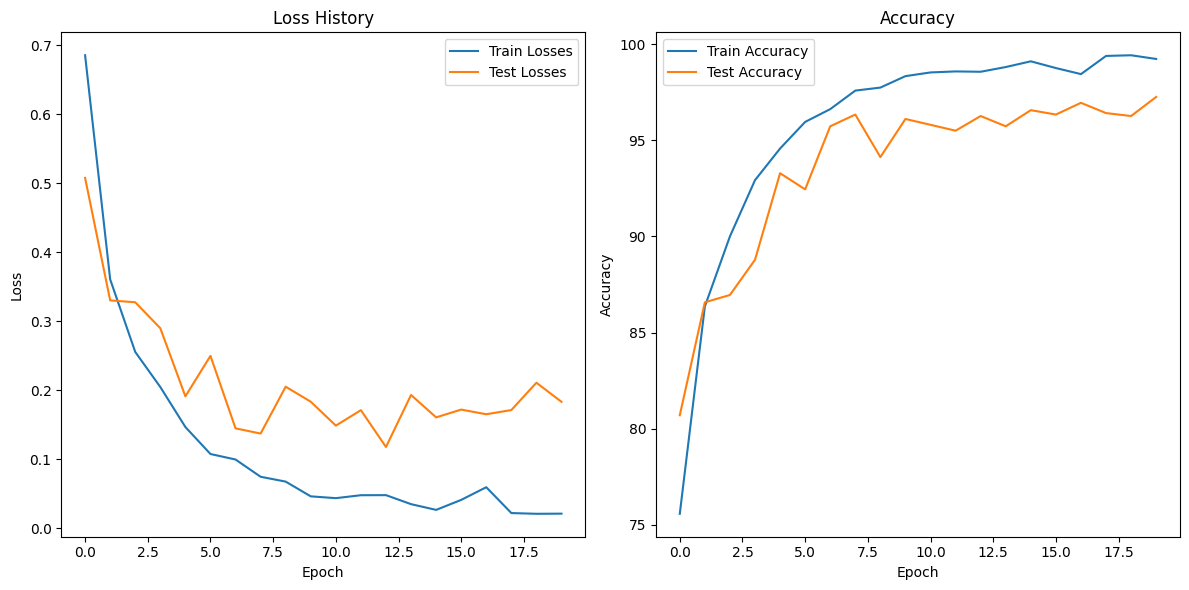

In [21]:
# visualizing the training history

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot([x.detach().cpu() if torch.is_tensor(x) else x for x in train_loss_history], label="Train Losses")
plt.plot([x.detach().cpu() if torch.is_tensor(x) else x for x in test_loss_history], label="Test Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()

plt.subplot(1,2,2)
plt.plot([x.detach().cpu() if torch.is_tensor(x) else x for x in train_acc_history], label="Train Accuracy")
plt.plot([x.detach().cpu() if torch.is_tensor(x) else x for x in test_acc_history], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
print(f"Training history plot saved to: {MODEL_DIR / 'training_history.png'}")
plt.show()

In [22]:
# Save final model
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_history': train_loss_history,
    'test_loss_history': test_loss_history,
    'train_acc_history': train_acc_history,
    'test_acc_history': test_acc_history,
    'class_names': class_names,
    'class_to_index': class_to_index
}, MODEL_DIR / 'final_model.pth')

print(f"Final model saved to: {MODEL_DIR / 'final_model.pth'}")
print(f"Best model saved to: {MODEL_DIR / 'best_model.pth'}")

Final model saved to: model/final_model.pth
Best model saved to: model/best_model.pth
